In [4]:
import numpy as np
import matplotlib.pyplot as plt
import instaseis
from scipy import signal
from europa_seismo.europa_seismo import get_corner_freq
#import mpld3
#mpld3.enable_notebook()
%matplotlib inline
plt.style.use(['fivethirtyeight'])

ImportError: cannot import name get_corner_freq

### Modeling high frequency accelerations on Europa

It is not feasible to model global wave propagation at frequency much higher than 1 Hz. However, it is useful to consider higher frequency waves since seismic source spectra may contain significant energy above 1 Hz. In order to do this, we use the following equation

$A(\omega) = -\omega \mathrm{G}e^{\frac{-\pi f_c t}{Q}} M_0  |  \mathrm{sinc}\left(\omega T_R / 2 \right) * \mathrm{sinc}\left(\omega T_D / 2 \right)| $

where $A(\omega)$ is the acceleration spectrum, $\mathrm{G}$ is a scaling term that accounts for geometric spreading and scattering from first order discontinuties, $t$ is the travel time, $Q$ is the quality factor, $M_0$ is the moment magnitude, $f_c$ is the corner frequency of the source, and $T_R$ and $T_D$ are the rise time and duration of the source, respectively. The scaling term $\mathrm{G}$ is determined from axisem synthetics calculated using a minimum period of 1 s.

The corner frequency $f_c$ is related to the moment magnitude with the following relationship (e.g., Allmann and Shearer, 2009)

$M_0 = \Delta\sigma \left( \frac{f_c}{0.42V_S} \right)^{-3} $

where $\Delta\sigma$ is the stress drop and $V_S$ is the shear velocity. For ice, a reasonable range of values of stress drop is $10^{-4} \lt \Delta\sigma \lt 1.5 $ MPa (e.g., Podolskiy et al. 2016). $V_S$ in the ice shell is approximately 2.0 km/s.

### Instaseis seismograms

Text(0,0.5,u'disp. (m)')

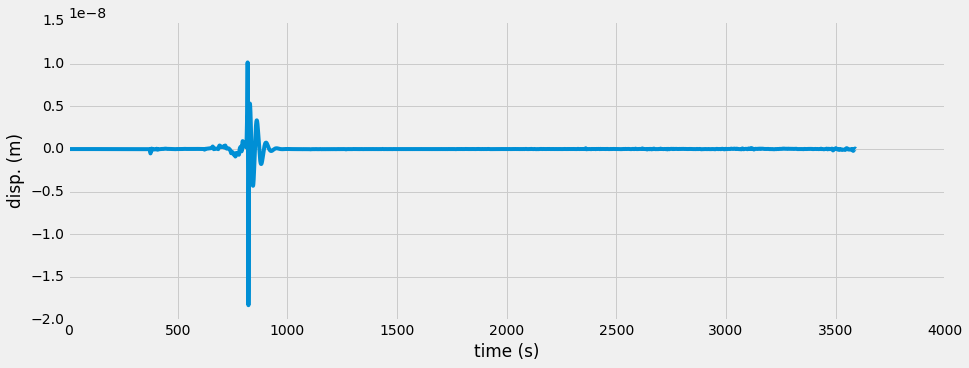

In [132]:
gcarc = 50.0
db = instaseis.open_db('/Volumes/G-RAID with Thunderbolt/axisem_databases/Mars_EH45Tcold_5s_noatten_database')
source = instaseis.Source(latitude=0.0,longitude=0.0,depth_in_m=1000.0,m_rr=3.98e13,m_pp=-3.98e13)
receiver = instaseis.Receiver(latitude=0.0,longitude=gcarc)
st = db.get_seismograms(source,receiver,components='Z',
                        kind='displacement',remove_source_shift=True)
st.resample(10.0)
t = np.linspace(0,st[0].stats.npts*st[0].stats.delta,st[0].stats.npts)
fig,ax = plt.subplots(1,figsize=(14,5))
ax.plot(t,st[0].data)
ax.set_xlabel('time (s)')
ax.set_ylabel('disp. (m)')
#st.plot()

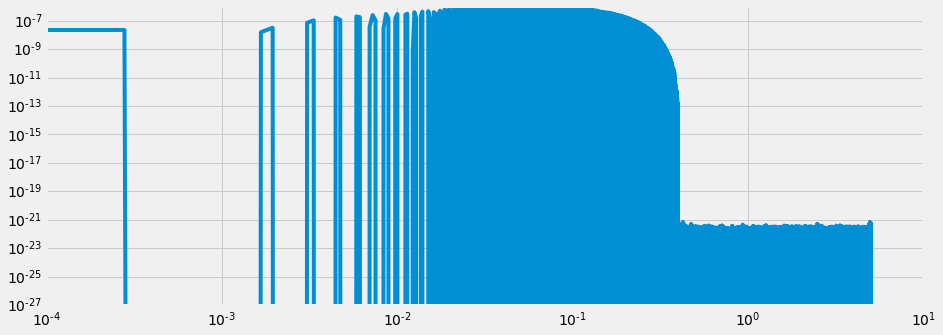

In [133]:
signal_w = np.fft.fft(st[0].data)
w = np.fft.fftfreq(len(st[0].data),st[0].stats.delta)
power = np.abs(signal_w)**2
fig,ax = plt.subplots(1,figsize=(14,5))
ax.loglog(w,signal_w)

### Haskell model

/Users/rossmaguire/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rossmaguire/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


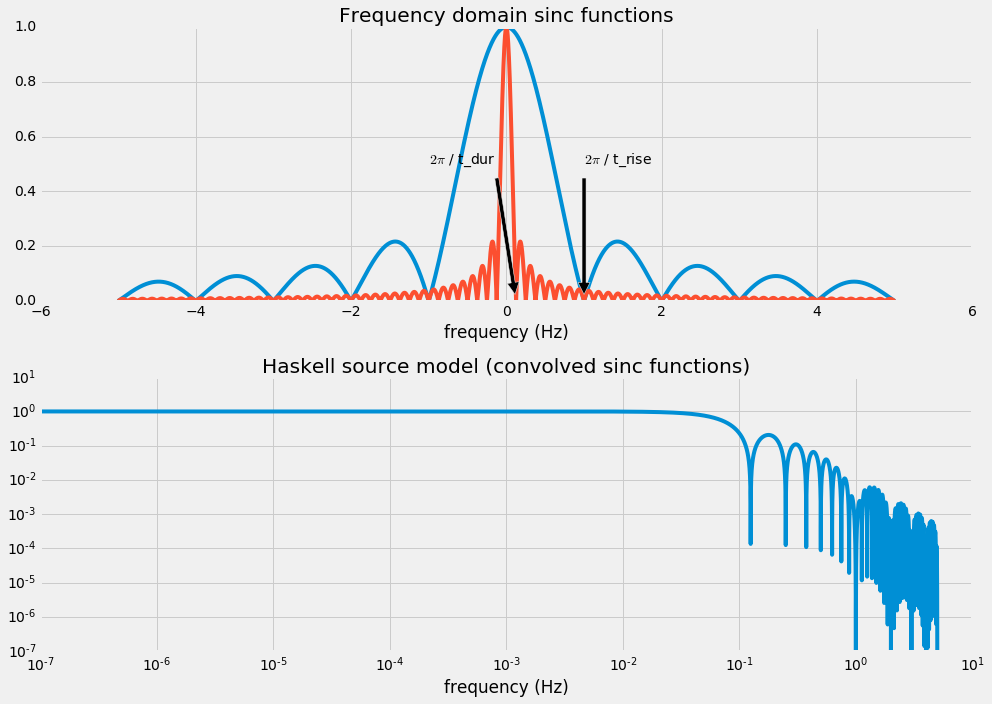

In [134]:
t_rise = 2.*np.pi
t_dur = 16.*np.pi
sinc1 = np.sin((w*t_rise)/2.)/(w*t_rise/2.)
sinc2 = np.sin((w*t_dur)/2.)/(w*t_dur/2.)
sinc1[0] = 1.0
sinc2[0] = 1.0
sinc1 = np.abs(sinc1)
sinc2 = np.abs(sinc2)
haskell = sinc1*sinc2

#plot
fig,ax = plt.subplots(2,figsize=(14,10))
ax[0].plot(np.fft.fftshift(w),np.fft.fftshift(sinc1))
ax[0].plot(np.fft.fftshift(w),np.fft.fftshift(sinc2))

ax[0].annotate("$2\pi$ / t_rise", xy=((np.pi*2./t_rise),0), xytext=(1.0, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].annotate("$2\pi$ / t_dur", xy=((np.pi*2./t_dur),0), xytext=(-1.0, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Frequency domain sinc functions')
ax[0].set_xlabel('frequency (Hz)')

ax[1].loglog(np.fft.fftshift(w),np.fft.fftshift(haskell))
ax[1].set_title('Haskell source model (convolved sinc functions)')
ax[1].set_xlabel('frequency (Hz)')
ax[1].set_ylim([1e-7,1e1])
ax[1].set_xlim([1e-7,1e1])
plt.tight_layout()